<h1>Содержание<span class="tocSkip"></span></h1>
<ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1.1">1. Подготовка</a></span></li><li><span><a href="#2.-Первичный-анализ" data-toc-modified-id="2.-Первичный-анализ-1.2">2. Первичный анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.2.1">Вывод</a></span></li></ul><li><span><a href="#3.-Обучение" data-toc-modified-id="3.-Обучение-1.3">3. Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-1.4">Выводы</a></span></li>

# Проект для интернет-магазина

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import re
import seaborn as sns
import time
from tqdm import tqdm


from lightgbm import LGBMClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

stop_words = stopwords.words('english')
RND = 2102

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def first_check(df):
    """ Ф-ция first look на фрейм """
    print(df.info())
    display(df)
    display(df['toxic'].value_counts())
    
    all_comments = df['toxic'].value_counts()[0] + df['toxic'].value_counts()[1]
    toxic_comments = df['toxic'].value_counts()[1]
    
    sns.barplot(x=[0,1], y=df['toxic'].value_counts())
    plt.title("toxic hist")
    plt.xlabel("не токсичный/токсичный")
    plt.ylabel("Кол-во")
    plt.show()
    
    print(f"Токсичных комментариев: {round(toxic_comments/all_comments * 100, 2)}%")
    print(f"Количество дубликатов: {df.duplicated().sum()}")

In [3]:
def text_processing(text):
        """ Обработка текста с помощью регулярных выражений """
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "cannot ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text)
        text = re.sub('\s+', ' ', text)
        text = text.strip(' ')
        return text

In [4]:
class toxic_classification():
    """
    Класс реализующий все этапы предобработки и классификацию комментариев (токсичный/не токсичный)
    """
    def __init__(self, start_df,
                 data_column,
                 target_column,
                 stop_words,
                 score: str,
                 models_whith_params,
                 text_clearing=False):
        """ Инициализация параметров """
        self.start_df = start_df
        self.data_column = data_column
        self.target_column = target_column
        self.stop_words = stop_words
        self.score = score
        self.models_whith_params = models_whith_params
        self.text_clearing = text_clearing
        self.max_score = -1
    
        # preprocessing
        print('---- Подготовка корпуса (1/3) ----')
        self.pre_time = time.time()
        self.start_time = time.time()
        self.__corpus_preparation()
        self.total_time = time.time() - self.start_time
        print(f"Первый этап пройден за {round(self.total_time, 2)} сек.\n")
        
        print('---- Лемматизации корпуса (2/3) ----')
        self.start_time = time.time()
        self.__lemmatisation()
        self.total_time = time.time() - self.start_time
        print(f"Второй этап пройден за {round(self.total_time, 2)} сек.\n")
        
        print('---- Разбиение на train/test (3/3) ----')
        self.start_time = time.time()
        self.__tt_splitter()
        self.total_time = time.time() - self.start_time
        print(f"Третий этап пройден за {round(self.total_time, 2)} сек.\n")
        
        self.all_time = time.time() - self.pre_time
        print(f"Общее время {self.all_time}")
        
        del self.pre_time, self.start_time, self.total_time, self.all_time
        

    def __corpus_preparation(self):
        """ Ф-ция подготовки корпуса """
        # Выделение корпуса
        corpus = self.start_df[self.data_column].str.lower()
        # Очистка корпуса от лишних символов
        match self.text_clearing:
            case True:
                self.corpus = corpus.apply(lambda sentence: text_processing(sentence))
                self.corpus = self.corpus.apply(lambda sentence: re.sub(r'[^a-z]',' ', sentence))
            case _:
                self.corpus = corpus.apply(lambda sentence: re.sub(r'[^a-z]',' ', sentence))
            

    def __lemmatisation(self):
        """ Ф-ция по лемматизации слов корпуса """
        wnl = WordNetLemmatizer()
        # Лемматизация корпуса
        self.lemm_corpus = self.corpus.apply(lambda sentence: " ".join([wnl.lemmatize(w,"n") for w in nltk.word_tokenize(sentence)]))
        
        
    def __tt_splitter(self):
        """ Ф-ция разбиения на train/test """
        self.split_df = train_test_split(self.lemm_corpus,
                                         self.start_df[self.target_column],
                                         test_size = 0.2, random_state=RND)
        
        self.splited_data = {
            "train": {
                "features": self.split_df[0],
                "target": self.split_df[2],
            },
            "test": {
                "features": self.split_df[1],
                "target": self.split_df[3],
            },
            
        }


    def fit(self):
        """ 
            Ф-ция тренировки переданных моделей 
        Буду использовать словарь black_box для хранения информации.
        
        Структура хранения в словаре black_box:
        black_box[Имя модели][Информация по модели]
        
        Под информацией модели подразумеваю:
        1) "grid_object"
        2) "best_model"
        3) "best_score_train"
        4) "best_score_test"
        5) "train_time"
        6) "predict_time"
        """
        # Инициализация словаря
        self.black_box = {str(name):{} for name, _, _ in self.models_whith_params}
        # Перебор моделей с параметрами
        for model, params, model_name in tqdm(self.models_whith_params):
            # Инициализация/тренировка грид серча
            self.black_box[str(model)]["grid_object"] = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring=self.score)
            self.start_time = time.time()
            self.black_box[str(model)]["grid_object"].fit(
                self.splited_data['train']['features'],
                self.splited_data['train']['target'],
            )
            self.train_time = time.time() - self.start_time
            self.black_box[str(model)]["train_time"] = self.train_time
            # Сохранение лучшей модели
            self.black_box[str(model)]["best_model"] = self.black_box[str(model)]["grid_object"].best_estimator_
            # Сохранение скоров
            self.black_box[str(model)]["best_score_train"] = self.black_box[str(model)]["grid_object"].best_score_
            self.start_time = time.time()
            self.black_box[str(model)]["best_score_test"] = f1_score(self.splited_data['test']['target'], self.black_box[str(model)]["best_model"].predict(self.splited_data['test']['features']))
            self.predict_time = time.time() - self.start_time
            self.black_box[str(model)]["pred_time"] = self.predict_time

            # Сохранение лучшей модели
            if self.max_score < self.black_box[str(model)]["best_score_test"]:
                self.max_score = self.black_box[str(model)]["best_score_test"]
                self.best_model = self.black_box[str(model)]["best_model"]
                self.best_model_score = (self.black_box[str(model)]["best_score_train"], self.black_box[str(model)]["best_score_test"])
                self.best_model_time = (self.train_time, self.predict_time)
            
            del self.start_time, self.train_time, self.predict_time
            
        return {"best_scores": self.best_model_score, "best_model": self.best_model, "time": self.best_model_time}
        
        
    def get_black_box(self):
        """ Ф-ция возвращает всю собранную информацию об обучении """
        black_box = self.black_box
        return black_box

        
    def report(self):
        """ Ф-ци для создания таблицы с результатами"""
        col = []
        best_score_train = []
        best_score_test = []
        train_time = []
        pred_time = []
        
        for model, params, model_name in self.models_whith_params:
            col.append(model_name)
            best_score_train.append(self.black_box[str(model)]["best_score_train"])
            best_score_test.append(self.black_box[str(model)]["best_score_test"])
            train_time.append(self.black_box[str(model)]["train_time"])
            pred_time.append(self.black_box[str(model)]["pred_time"])
            
        report = pd.DataFrame(
            columns = col,
            index = [
                'best_score_train',
                'best_score_test',
                'train_time',
                'pred_time',
            ]
        )
        
        report.iloc[0] = best_score_train
        report.iloc[1] = best_score_test
        report.iloc[2] = train_time
        report.iloc[3] = pred_time
        
        return report

## 2. Первичный анализ

In [5]:
pth1 = '/datasets/toxic_comments.csv'
pth2 = './data/toxic_comments.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


0    143346
1     16225
Name: toxic, dtype: int64

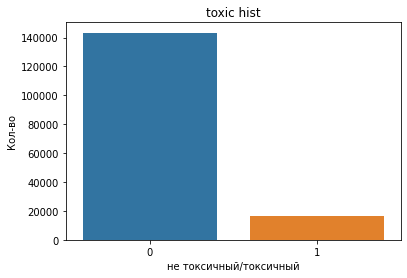

Токсичных комментариев: 10.17%
Количество дубликатов: 0


In [6]:
first_check(df)

### Вывод

* 159571 строка;
* Дубликатов и пропусков нет;
* 2 столбца: `text`(features), `toxic`(target); 
* В столбце `text` содержатся тексты твитов;
* В столбе `toxic` булевые значения является ли данный твит токсичным или нет;
* 90% твитов не токсичны.

## 3. Обучение

In [7]:
# Инициализация пайплайнов
pipe_lr_TFIDF = Pipeline(
    [('vect', TfidfVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('clf', LogisticRegression(random_state=RND, class_weight='balanced', n_jobs=-1)),]
)
pipe_lr_CV = Pipeline(
    [('vect', CountVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('clf', LogisticRegression(random_state=RND, class_weight='balanced', n_jobs=-1)),]
)


pipe_rf_TFIDF = Pipeline(
    [('vect', TfidfVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('model', RandomForestClassifier(random_state=RND, class_weight='balanced', n_jobs=-1)),]
)
pipe_rf_CV = Pipeline(
    [('vect', CountVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('model', RandomForestClassifier(random_state=RND, class_weight='balanced', n_jobs=-1)),]
)


pipe_lgbm_TFIDF = Pipeline(
    [('vect', TfidfVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('model', LGBMClassifier(random_state=RND, n_jobs=-1)),]
)
pipe_lgbm_CV = Pipeline(
    [('vect', CountVectorizer(stop_words = stop_words, dtype=np.float32)),
     ('model', LGBMClassifier(random_state=RND, n_jobs=-1))]
)

In [8]:
# Инициализация параметров
grid_params_lr ={
    "clf__max_iter": [1000],
    "clf__C": [0.5, 1, 10],
}

grid_params_rf = {
    "model__n_estimators": [40, 80],
    "model__max_depth": [2, 10],
}

grid_params_lgbm = {
    "model__n_estimators": [200],
    'model__learning_rate': [0.25, 0.4, 0.55],
    'model__max_depth': [-1],
}

In [9]:
%%time

# Инициализация класса
cl = toxic_classification(
    df,
    'text',
    'toxic',
    stop_words,
    'f1',
    [(pipe_lr_TFIDF, grid_params_lr, "LogisticRegression(TFIDF)"),
     (pipe_lr_CV, grid_params_lr, "LogisticRegression(CountVect)"),
     (pipe_rf_TFIDF, grid_params_rf, "RandomForestClassifier(TFIDF)"),
     (pipe_rf_CV, grid_params_rf, "RandomForestClassifier(CountVect)"),
     (pipe_lgbm_TFIDF, grid_params_lgbm, "LGBMClassifier(TFIDF)"),
     (pipe_lgbm_CV, grid_params_lgbm, "LGBMClassifier(CountVect)"),],
    text_clearing=True,
)

---- Подготовка корпуса (1/3) ----
Первый этап пройден за 15.08 сек.

---- Лемматизации корпуса (2/3) ----
Второй этап пройден за 90.85 сек.

---- Разбиение на train/test (3/3) ----
Третий этап пройден за 0.04 сек.

Общее время 105.96525764465332
CPU times: total: 1min 45s
Wall time: 1min 45s


In [10]:
%%time

best_model = cl.fit()
best_model

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [08:42<00:00, 87.02s/it]

CPU times: total: 16min 5s
Wall time: 8min 42s


{'best_scores': (0.7700835554722718, 0.7764787995114291),
 'best_model': Pipeline(steps=[('vect',
                  TfidfVectorizer(dtype=<class 'numpy.float32'>,
                                  stop_words=['i', 'me', 'my', 'myself', 'we',
                                              'our', 'ours', 'ourselves', 'you',
                                              "you're", "you've", "you'll",
                                              "you'd", 'your', 'yours',
                                              'yourself', 'yourselves', 'he',
                                              'him', 'his', 'himself', 'she',
                                              "she's", 'her', 'hers', 'herself',
                                              'it', "it's", 'its', 'itself', ...])),
                 ('model',
                  LGBMClassifier(learning_rate=0.25, n_estimators=200,
                                 random_state=2102))]),
 'time': (206.27367615699768, 2.1373634338378906)}

## Выводы

* Для анализа данных и построения модели предоставлен датасет с размеченными данными, содержащий комментарии пользователей к товарам, доступным для приобретения в интернет-магазине. Датасет состоит из 2 столбцов с данными и 159571 строкой;
* Проверка соотношения классов показала, что в датасете имеет место явный дисбаланс;
* В качестве моделей использованы `LogisticRegression`, `RandomForestClassifier` и `LGBMClassifier`:

In [11]:
rep = cl.report()
display(rep)

,LogisticRegression(TFIDF),LogisticRegression(CountVect),RandomForestClassifier(TFIDF),RandomForestClassifier(CountVect),LGBMClassifier(TFIDF),LGBMClassifier(CountVect)
best_score_train,0.760862,0.755888,0.362593,0.350868,0.770084,0.765841
best_score_test,0.758229,0.757515,0.352618,0.345198,0.776479,0.77337
train_time,55.668713,135.146905,24.684095,24.323995,206.273676,63.480782
pred_time,1.843055,2.061003,2.029255,1.939591,2.137363,2.091913


* `LogisticRegression(TFIDF)`, `LogisticRegression(CountVect)`, `LGBMClassifier(TFIDF)` и `LGBMClassifier(CountVect)` успешно преодалели порог в 0.75 на тесте (по Т.З.);
* В зависимости от пожеланий заказчика сможем ему предложить подходящую модель:
    * Если заказчика не волнует время обучения модели, а интересует только скор на тестовой выборке, то сможем ему предложить `LGBMClassifier(TFIDF)`;
    * Если заказчику понадобится самая быстрая модель, но с меньшей точностью предсказания, то предложим `LogisticRegression(TFIDF)`;
    * Если понадобится модель с хорошей скоростью и скором, то сможем предложить `LGBMClassifier(CountVect)`.
* На мой взгляд лучшей моделью будет `LGBMClassifier(CountVect)`, так мы сможем помочь заказчику сэкономть время и вычислителную мощность.